In [143]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import dtale

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from collections import Counter


In [123]:
df_leagues = pd.read_csv('../data/csv/Leagues.csv', index_col=0)

df_leagues.drop(['date', 'matchweek', 'home_team_id', 'away_team_id', 'home_team', 'away_team', 'home_manager', 'away_manager', 'home_xg', 'away_xg', 'home_formation', 'away_formation'], axis=1, inplace=True)
print(f'Nb NaN: {df_leagues.isna().sum().sum()}')

df_leagues['home_team_form'] = df_leagues['home_team_form'].fillna('')
df_leagues['home_team_home_form'] = df_leagues['home_team_home_form'].fillna('')
df_leagues['home_team_average_goals_form'] = df_leagues['home_team_average_goals_form'].fillna(0)
df_leagues['home_team_average_xg_form'] = df_leagues['home_team_average_xg_form'].fillna(0)
df_leagues['home_team_average_goals_form_against'] = df_leagues['home_team_average_goals_form_against'].fillna(0)
df_leagues['home_team_average_xg_form_against'] = df_leagues['home_team_average_xg_form_against'].fillna(0)
df_leagues['away_team_form'] = df_leagues['away_team_form'].fillna('')
df_leagues['away_team_away_form'] = df_leagues['away_team_away_form'].fillna('')
df_leagues['away_team_average_goals_form'] = df_leagues['home_team_average_goals_form'].fillna(0)
df_leagues['away_team_average_xg_form'] = df_leagues['home_team_average_xg_form'].fillna(0)
df_leagues['away_team_average_goals_form_against'] = df_leagues['home_team_average_goals_form_against'].fillna(0)
df_leagues['away_team_average_xg_form_against'] = df_leagues['home_team_average_xg_form_against'].fillna(0)


def calculate_points(results):
    points_map = {'W': 3, 'D': 1, 'L': 0}
    return sum(points_map[char] for char in results)

df_leagues['home_team_form'] = df_leagues['home_team_form'].apply(calculate_points)
df_leagues['away_team_form'] = df_leagues['away_team_form'].apply(calculate_points)

df_leagues['home_team_home_form'] = df_leagues['home_team_home_form'].apply(calculate_points)
df_leagues['away_team_away_form'] = df_leagues['away_team_away_form'].apply(calculate_points)

print(f'Nb NaN: {df_leagues.isna().sum().sum()}')

Nb NaN: 3828
Nb NaN: 0


In [124]:
def get_train_test_split(df: pd.DataFrame, label_name:str = 'home_goals') -> (pd.DataFrame, pd.DataFrame, pd.Series, pd.Series):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

    y_train = df_train[f'{label_name}']
    y_test = df_test[f'{label_name}']

    del df_train[f'{label_name}']
    del df_test[f'{label_name}']
    
    return df_train, df_test, y_train, y_test


def get_X_train_test(df_train:pd.DataFrame, df_test:pd.DataFrame):
    dict_vectorizer = DictVectorizer(sparse=False)
    train_serie_dict = df_train.to_dict(orient='records')
    test_serie_dict = df_test.to_dict(orient='records')

    X_train = dict_vectorizer.fit_transform(train_serie_dict)
    X_test = dict_vectorizer.transform(test_serie_dict)
    
    return X_train, X_test, dict_vectorizer


### Predict Result

In [ ]:
df_leagues_scores = df_leagues.copy()
df_leagues_scores['result'] = [0 if x == 0 else 1 if x > 0 else 2 for x in df_leagues_scores['home_goals'] - df_leagues_scores['away_goals']]

df_train_score, df_test_score, y_train_score, y_test_score = get_train_test_split(df_leagues_scores, 'result')

del df_train_score['home_goals']
del df_train_score['away_goals']
del df_test_score['home_goals']
del df_test_score['away_goals']

X_train_score, X_test_score, score_dict_vectorizer = get_X_train_test(df_train_score, df_test_score)

df_result_accuracy = pd.DataFrame(columns=['max_depth', 'n_estimators', 'min_samples_split', 'accuracy_rf'])

class_counts = Counter(y_train_score)
print(class_counts)

doubt_weight = (class_counts[0] + class_counts[1] + class_counts[2]) / class_counts[0]
home_weight = (class_counts[0] + class_counts[1] + class_counts[2]) / class_counts[1]
away_weight = (class_counts[0] + class_counts[1] + class_counts[2]) / class_counts[2]

print(f'Home weight: {home_weight} | Doubt weight: {doubt_weight} | Away weight: {away_weight}')
class_weights = {0: doubt_weight, 1: home_weight, 2: away_weight}

for max_depth in tqdm(range(5,40,1)):
    print(f'Max depth: {max_depth}')
    for n_estimator in range(200, 600, 50):
        for min_samples_split in range(2,16,2):
            r_rf_model = RandomForestClassifier(max_depth=max_depth, 
                                                n_estimators=n_estimator,
                                                min_samples_split= min_samples_split,
                                                class_weight= class_weights,
                                                random_state=42)
            r_rf_model.fit(X_train_score, y_train_score)
            y_pred_result = r_rf_model.predict(X_test_score)

            tmp_score_rf = accuracy_score(y_test_score, y_pred_result)
            
            df_temp = pd.DataFrame([{'max_depth':max_depth,
                                        'n_estimators': n_estimator,
                                        'min_samples_split':min_samples_split,
                                        'accuracy_rf':tmp_score_rf}])
            
            if df_result_accuracy.empty:
                df_result_accuracy = df_temp
            else:
                df_result_accuracy = pd.concat([df_result_accuracy, df_temp], ignore_index = True)
    
df_result_accuracy = df_result_accuracy.sort_values('accuracy_rf', ascending=False)
df_result_accuracy.head(10)

Counter({1: 1772, 2: 1346, 0: 1078})
Home weight: 2.3679458239277653 | Doubt weight: 3.8923933209647497 | Away weight: 3.1173848439821694


,max_depth,n_estimators,min_samples_split,accuracy_rf
0,26,400,2,0.656816
2,26,400,6,0.646330
1,26,400,4,0.645377
4,26,400,10,0.636797
6,26,400,14,0.636797
3,26,400,8,0.634890
5,26,400,12,0.634890


In [ ]:
result_model = RandomForestClassifier(max_depth=26, 
                                      n_estimators=400,
                                      min_samples_split= 2,
                                      class_weight= class_weights,
                                      random_state=42)
result_model.fit(X_train_score, y_train_score)

features = list(score_dict_vectorizer.feature_names_)
importances = result_model.feature_importances_

feature_importances = pd.DataFrame({'feature': features, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
5,away_team_away_league_pos,0.104399
16,home_team_home_league_pos,0.095497
17,home_team_home_points_diff,0.053683
19,home_team_points_diff,0.052321
9,away_team_points_diff,0.051732
8,away_team_league_pos,0.049981
18,home_team_league_pos,0.049822
12,home_team_average_xg_form,0.049792
2,away_team_average_xg_form,0.048731
6,away_team_away_points_diff,0.048543


In [175]:
y_pred_score = result_model.predict(X_test_score)
accuracy_result = accuracy_score(y_test_score, y_pred_score)

print(f'Accuracy: {accuracy_result}')

Accuracy: 0.6568160152526216


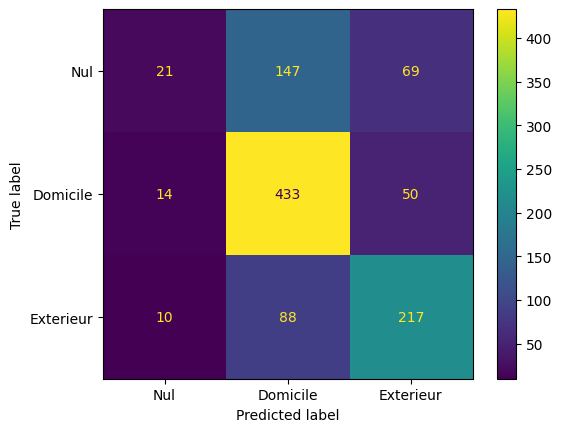

In [202]:
y_proba_result = result_model.predict_proba(X_test_score)

#for i in np.linspace(0.3,0.4, 20):
y_pred_score = [1 if x[1] > 0.33 else 2 if x[2] > 0.33 else 0 for x in y_proba_result]

accuracy_result = accuracy_score(y_test_score, y_pred_score)
#print(f'Threshold: {i} -> Accuracy: {accuracy_result}')
    
cm = confusion_matrix(y_test_score, y_pred_score)
ConfusionMatrixDisplay(cm, display_labels=['Nul', 'Domicile', 'Exterieur']).plot()

In [184]:
print(classification_report(y_test_score, y_pred_score))

              precision    recall  f1-score   support

           0       0.42      0.13      0.20       237
           1       0.67      0.85      0.75       497
           2       0.65      0.71      0.68       315

    accuracy                           0.65      1049
   macro avg       0.58      0.57      0.54      1049
weighted avg       0.61      0.65      0.61      1049



In [185]:
X_full_home = np.concatenate([X_train_score, X_test_score], axis=0)
y_pred_score_full = result_model.predict(X_full_home)

df_leagues['predicted_result'] = np.where( y_pred_score_full == 1, 'H',  np.where(y_pred_score_full == 2, 'A', 'D'))
df_leagues.head(5)

,league,home_goals,away_goals,home_team_form,home_team_league_pos,home_team_points_diff,home_team_home_form,home_team_home_league_pos,home_team_home_points_diff,home_team_average_goals_form,...,away_team_league_pos,away_team_points_diff,away_team_away_form,away_team_away_league_pos,away_team_away_points_diff,away_team_average_goals_form,away_team_average_xg_form,away_team_average_goals_form_against,away_team_average_xg_form_against,predicted_result
0,Premier League,1,0,0,1.0,0,0,1.0,0,0.000000,...,1.0,0,0,1.0,0,0.000000,0.000000,0.000000,0.000000,A
1,Premier League,1,3,8,14.0,6,4,15.0,5,1.000000,...,7.0,-2,5,2.0,2,1.000000,0.633333,1.000000,1.533333,H
2,Premier League,1,1,0,1.0,0,0,1.0,0,0.000000,...,1.0,0,0,1.0,0,0.000000,0.000000,0.000000,0.000000,A
3,Premier League,2,1,7,10.0,-12,4,7.0,-5,1.666667,...,8.0,1,0,19.0,0,1.666667,1.833333,1.666667,1.300000,H
4,Premier League,1,0,6,9.0,-2,2,12.0,-4,0.666667,...,18.0,-1,1,17.0,-2,0.666667,1.033333,1.000000,1.066667,H


### Predict Home

In [42]:
df_train_home, df_test_home, y_train_home, y_test_home = get_train_test_split(df_leagues, 'home_goals')
X_train_home, X_test_home, home_dict_vectorizer = get_X_train_test(df_train_home, df_test_home)

y_train_home_no_goal = (y_train_home == 0).astype(int)
y_train_home_one_goal = (y_train_home >= 1).astype(int)
y_train_home_two_goal = (y_train_home >= 2).astype(int)
y_train_home_three_goal = (y_train_home >= 3).astype(int)

y_test_home_no_goal = (y_test_home == 0).astype(int)
y_test_home_one_goal = (y_test_home >= 1).astype(int)
y_test_home_two_goal = (y_test_home >= 2).astype(int)
y_test_home_three_goal = (y_test_home >= 3).astype(int)

y_train_home_combined = np.column_stack([y_train_home_no_goal, y_train_home_one_goal, y_train_home_two_goal, y_train_home_three_goal])
y_test_home_combined = np.column_stack([y_test_home_no_goal, y_test_home_one_goal, y_test_home_two_goal, y_test_home_three_goal])

h_model = MultiOutputClassifier(XGBClassifier(random_state=42))

param_grid = {
    "estimator__max_depth": range(5,60, 5),
    "estimator__learning_rate": [0.01, 0.1],
    "estimator__n_estimators": [200],
    "estimator__subsample": [0.8],
    "estimator__colsample_bytree": [0.8],
}

grid_search = GridSearchCV(
    estimator = h_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_home, y_train_home_combined)


print('---------------------------------------------------------------------------')
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score :", grid_search.best_score_)

home_model = grid_search.best_estimator_

Fitting 5 folds for each of 22 candidates, totalling 110 fits
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.4s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.5s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.5s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.5s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.6s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator_

In [43]:
y_pred_home = home_model.predict(X_test_home)

accuracy_zero = accuracy_score(y_test_home_no_goal, y_pred_home[:,0])
accuracy_one = accuracy_score(y_test_home_one_goal, y_pred_home[:,1])
accuracy_two = accuracy_score(y_test_home_two_goal, y_pred_home[:,2])
accuracy_three = accuracy_score(y_test_home_three_goal, y_pred_home[:,3])

print(f'Accuracy: 0 Goal -> {accuracy_zero} | 1 Goals -> {accuracy_one} | 2 Goals -> {accuracy_two} | 3 Goals -> {accuracy_three}')

Accuracy: 0 Goal -> 0.789544235924933 | 1 Goals -> 0.789544235924933 | 2 Goals -> 0.7493297587131368 | 3 Goals -> 0.8257372654155496


### Predict Away

In [44]:
#Predict away goals
df_train_away, df_test_away, y_train_away, y_test_away = get_train_test_split(df_leagues, 'away_goals')
X_train_away, X_test_away, away_dict_vectorizer = get_X_train_test(df_train_away, df_test_away)

y_train_away_no_goal = (y_train_away == 0).astype(int)
y_train_away_one_goal = (y_train_away >= 1).astype(int)
y_train_away_two_goal = (y_train_away >= 2).astype(int)
y_train_away_three_goal = (y_train_away >= 3).astype(int)

y_test_away_no_goal = (y_test_away == 0).astype(int)
y_test_away_one_goal = (y_test_away >= 1).astype(int)
y_test_away_two_goal = (y_test_away >= 2).astype(int)
y_test_away_three_goal = (y_test_away >= 3).astype(int)

y_train_away_combined = np.column_stack([y_train_away_no_goal, y_train_away_one_goal, y_train_away_two_goal, y_train_away_three_goal])
y_test_away_combined = np.column_stack([y_test_away_no_goal, y_test_away_one_goal, y_test_away_two_goal, y_test_away_three_goal])

a_model = MultiOutputClassifier(XGBClassifier(random_state=42))

param_grid = {
    "estimator__max_depth": range(5,60, 5),
    "estimator__learning_rate": [0.01, 0.1],
    "estimator__n_estimators": [200],
    "estimator__subsample": [0.8],
    "estimator__colsample_bytree": [0.8],
}

grid_search = GridSearchCV(
    estimator = a_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_away, y_train_away_combined)


print('---------------------------------------------------------------------------')
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score :", grid_search.best_score_)

away_model = grid_search.best_estimator_

Fitting 5 folds for each of 22 candidates, totalling 110 fits
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.1s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.2s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.3s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.3s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   4.4s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator_

/Users/florian/Workspace/Learning/ml_zoomcamp/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   3.4s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   3.6s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.1, estimator__max_depth=5, estimator__n_estimators=200, estimator__subsample=0.8; total time=   3.6s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=55, estimator__n_estimators=200, estimator__subsample=0.8; total time=  11.0s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.01, estimator__max_depth=55, estimator__n_estimators=200, estimator__subsample=0.8; total time=  10.6s
[CV] END estimator__colsample_bytree=0.8, estimator__learning_rate=0.1, estimator__max_depth=10, estimator__n_estimators=200, estimator__subsample

In [45]:
y_pred_away = away_model.predict(X_test_away)

accuracy_zero = accuracy_score(y_test_away_no_goal, y_pred_away[:,0])
accuracy_one = accuracy_score(y_test_away_one_goal, y_pred_away[:,1])
accuracy_two = accuracy_score(y_test_away_two_goal, y_pred_away[:,2])
accuracy_three = accuracy_score(y_test_away_three_goal, y_pred_away[:,3])

print(f'Accuracy: 0 Goal -> {accuracy_zero} | 1 Goals -> {accuracy_one} | 2 Goals -> {accuracy_two} | 3 Goals -> {accuracy_three}')

Accuracy: 0 Goal -> 0.725201072386059 | 1 Goals -> 0.725201072386059 | 2 Goals -> 0.7506702412868632 | 3 Goals -> 0.8833780160857909


### Test

In [51]:
df_all_leagues = pd.read_csv('../data/csv/Leagues.csv', index_col=0)

def get_last_game_mu():
    df_premier_leagues = df_all_leagues[df_all_leagues['league'].str.contains('Premier League')]
    df_mu_last_game = df_premier_leagues[
        (df_premier_leagues['home_team'].str.contains('Manchester United')) & 
        (df_premier_leagues['away_team'].str.contains('Leicester'))].copy()
    df_mu_last_game = df_mu_last_game[df_mu_last_game['date'].str.contains('2024')].copy()
    #df_mu_last_game['date'] = pd.to_datetime(df_mu_last_game['date'], format='%A %B %d, %Y')
    #df_mu_last_game = df_mu_last_game.sort_values('date', ascending=False).head(1)
    
    return df_mu_last_game

df_mu_last_game = get_last_game_mu()
df_mu_last_game.drop(['league', 'matchweek', 'home_team_id', 'away_team_id', 'home_team', 'away_team', 'home_goals', 'away_goals'], axis=1, inplace=True)

X_score = score_dict_vectorizer.transform(df_mu_last_game.copy().to_dict(orient='records'))
mu_result = result_model.predict(X_score)
df_mu_last_game['predicted_result'] = mu_result

X_home_goal = home_dict_vectorizer.transform(df_mu_last_game.copy().to_dict(orient='records'))
X_away_goal = away_dict_vectorizer.transform(df_mu_last_game.copy().to_dict(orient='records'))

mu_home_goals = home_model.predict(X_home_goal)
mu_away_goals = away_model.predict(X_away_goal)


#df_leagues['result'] = [0 if x == 0 else 1 if x > 0 else 2 for x in df_leagues['home_goals'] - df_leagues['away_goals']]
#df_leagues['home_goals'] = y_pred_home_goals
#df_leagues['away_goals'] = y_pred_away_goals

df_mu_last_game = get_last_game_mu()
print(f'Manchester United vs {df_mu_last_game["away_team"].values[0]} -> {mu_home_goals} - {mu_away_goals} | {mu_result} | {df_mu_last_game["home_goals"].values[0]} - {df_mu_last_game["away_goals"].values[0]}')

df_mu_last_game

Manchester United vs Leicester City -> [[0 1 0 0]] - [[1 0 0 0]] | [1] | 3 - 0


,date,league,matchweek,home_team_id,home_team,home_manager,home_formation,home_goals,home_xg,away_xg,...,away_team_form,away_team_league_pos,away_team_points_diff,away_team_away_form,away_team_away_league_pos,away_team_away_points_diff,away_team_average_goals_form,away_team_average_xg_form,away_team_average_goals_form_against,away_team_average_xg_form_against
88,"Sunday November 10, 2024",Premier League,11,19538871,Manchester United,Ruud van Nistelrooy,4-2-3-1,3,0.8,0.6,...,LWWLD,15.0,4,LWD,10.0,-1,2.0,1.633333,2.333333,2.5
